# Calculating Expected Field Goal% (xFG%)

$xFG(x) = P$(`SHOT_MADE` $=1∣$ Shot Context)

### Features Used
| Feature                        | Why                       |
| ------------------------------ | ------------------------- |
| Shot location (x, y)           | Geometry                  |
| Shot distance                  | Nonlinear effect          |
| Shot angle                     | Corner vs above-the-break |
| Shot type (2PT / 3PT)          | Massive baseline shift    |
| Corner 3 indicator             | Known efficiency bump     |
| Shot clock time                | Rush effect               |
| Catch-and-shoot vs off-dribble | Difficulty                |
| Dribble count                  | Proxy for creation        |


In [1]:
# Imports
from __future__ import annotations
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss, brier_score_loss
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import shotchartdetail
import numpy as np
import pandas as pd
import json


In [ ]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent   # if notebook is in /notebooks
sys.path.append(str(ROOT))

from src.data_io.save_load import load_json, save_json
from src.viz.heatmaps import build_xfg_heatmap, plot_xfg_heatmap_with_labels
from src.viz.court import draw_half_court, draw_half_court_ft

from src.tracking.release import find_release_frame_idx
from src.processing.indexing import find_event_for_shot_by_clock, build_tracking_time_index
from src.features.defense_features import compute_pre_shot_defense_features
from src.processing.tracking_cleaning import dedupe_tracking_events
from src.pipelines.defensive_features import build_shot_defense_features
from src.features.shot_maps import make_grid, make_player_maps, build_player_maps
from src.data_io.maps import save_maps_npz



## Import Data

In [3]:
shots_raw = shotchartdetail.ShotChartDetail(
    team_id=0,                    # all teams
    player_id=0,                  # all players
    season_nullable="2015-16",
    season_type_all_star="Regular Season",
    context_measure_simple="FGA"  # field goal attempts
).get_data_frames()[0]


In [4]:
shots = shots_raw.copy()
# Coord Normalization
shots["x_ft"] = shots["LOC_X"] / 12
shots["y_ft"] = shots["LOC_Y"] / 12

shots["shot_dist"] = np.sqrt(shots.x_ft**2 + shots.y_ft**2)
shots["angle"] = np.arctan2(shots.x_ft, shots.y_ft)

# Shot Type
shots["is_three"] = shots["SHOT_TYPE"].str.contains("3PT").astype(int)
shots["is_corner"] = ((np.abs(shots.x_ft) > 22) & (shots.y_ft < 14)).astype(int)

# Shot Zone
shots['SHOT_ZONE_BASIC'] = shots['SHOT_ZONE_BASIC'].astype(str)

# Make Sure Game ID is int
shots['GAME_ID'] = shots['GAME_ID'].astype(int)

# Remove any shots past halfcourt
shots = shots[(shots["y_ft"] >= -5) & (shots["y_ft"] <= 42)]
shots = shots.reset_index(drop=True)


## Calculate xFG with Offensive Stats
Use shot chart data to calculate expected field goal for all shots

### Feature Pipeline

In [5]:
feature_cols_num = [
    "shot_dist",
    "angle",
    "is_three",
    "is_corner",
]

feature_cols_cat = ["SHOT_ZONE_BASIC"]

missing = [c for c in (feature_cols_num + feature_cols_cat) if c not in shots.columns]
if missing:
    raise ValueError(f"Missing features in shots: {missing}")

preprocess = ColumnTransformer([
    ("num", StandardScaler(), feature_cols_num),
    ("cat", OneHotEncoder(drop="first"), feature_cols_cat)
])

shots.fillna(0, inplace=True)

#### Test Train Split
60/20/20

In [6]:
shots["GAME_DATE"] = pd.to_datetime(shots["GAME_DATE"].astype(str), format="%Y%m%d", errors="coerce")
train_idx = shots.index[shots["GAME_DATE"] < "2016-01-01"]
val_idx   = shots.index[(shots["GAME_DATE"] >= "2016-01-01") & (shots["GAME_DATE"] < "2016-02-15")]
test_idx  = shots.index[shots["GAME_DATE"] >= "2016-02-15"]

### MODEL
Here we fit a logistic regression model, using "shot_made" as our target, then also fit a calibrated model which makes our data more normal.

In [7]:
num_cols = feature_cols_num
cat_cols = feature_cols_cat  

# Ensure cat_cols are strings
for c in cat_cols:
    shots[c] = shots[c].astype(str)

X_train = shots.loc[train_idx, num_cols + cat_cols]
y_train = shots.loc[train_idx, "SHOT_MADE_FLAG"].astype(int)

X_val   = shots.loc[val_idx, num_cols + cat_cols]
y_val   = shots.loc[val_idx, "SHOT_MADE_FLAG"].astype(int)

X_test  = shots.loc[test_idx, num_cols + cat_cols]
y_test  = shots.loc[test_idx, "SHOT_MADE_FLAG"].astype(int)

prep = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])

base_model = Pipeline([
    ("prep", prep),
    ("lr", LogisticRegression(
        l1_ratio=0.0,
        C=1.0,
        solver="lbfgs",
        max_iter=200
    ))
])

base_model.fit(X_train, y_train)

calibrator = CalibratedClassifierCV(
    estimator=base_model,
    method="isotonic"   # or "sigmoid" if you want smoother/less overfit
)

calibrator.fit(X_val, y_val)

,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2",Pipeline(step...x_iter=200))])
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'isotonic'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",None
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",'auto'
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the c

### Model Mectrics


In [8]:
def eval_probs(name, y_true, p):
    print(f"\n{name}")
    print("  log loss:", log_loss(y_true, p))
    print("  brier   :", brier_score_loss(y_true, p))

p_val  = calibrator.predict_proba(X_val)[:, 1]
p_test = calibrator.predict_proba(X_test)[:, 1]

eval_probs("Validation", y_val, p_val)
eval_probs("Test", y_test, p_test)


Validation
  log loss: 0.6507981711797041
  brier   : 0.23025401038273702

Test
  log loss: 0.6488665162824956
  brier   : 0.22885686752809967


#### Calibrate xFG

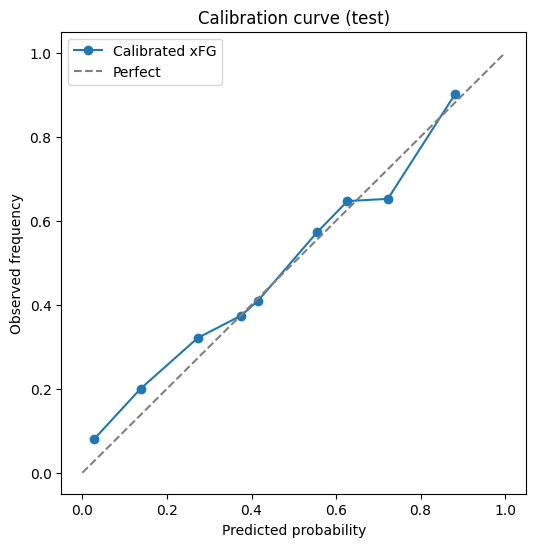

In [9]:
prob_true, prob_pred = calibration_curve(y_test, p_test, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker="o", label="Calibrated xFG")
plt.plot([0,1],[0,1], "--", color="gray", label="Perfect")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration curve (test)")
plt.legend()
plt.show()

### ADD Expected Points Per Shot

In [10]:
X_all = shots[feature_cols_num + feature_cols_cat].copy()
shots["xFG_base"]  = calibrator.predict_proba(X_all)[:,1]
shots["xPPS_base"] = shots["xFG_base"] * np.where(shots["is_three"], 3, 2)

## Add Offensive Impact of Player

In [11]:
alpha = 300
grp_cols = ["PLAYER_ID", "SHOT_ZONE_BASIC", "is_three"]

train = shots.loc[train_idx].copy()
league_rate = train["SHOT_MADE_FLAG"].mean()

grp = (
    train.groupby(grp_cols)["SHOT_MADE_FLAG"]
    .agg(["sum", "count"])
    .rename(columns={"sum": "makes", "count": "atts"})
    .reset_index()
)

grp["player_prior"] = (grp["makes"] + alpha * league_rate) / (grp["atts"] + alpha)
# 
min_atts = 30
grp.loc[grp["atts"] < min_atts, "player_prior"] = league_rate

shots = shots.drop(columns=["player_prior"], errors="ignore")
shots = shots.merge(grp[grp_cols + ["player_prior"]], on=grp_cols, how="left")
shots["player_prior"] = shots["player_prior"].fillna(league_rate)

offense_features = ["xFG_base", "player_prior", "is_three"]
X2_train = shots.loc[train_idx, offense_features]
y2_train = shots.loc[train_idx, "SHOT_MADE_FLAG"].astype(int)

X2_val   = shots.loc[val_idx, offense_features]
y2_val   = shots.loc[val_idx, "SHOT_MADE_FLAG"].astype(int)

offense_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(l1_ratio=0, C=1.0, solver="lbfgs", max_iter=500))
])

offense_model.fit(X2_train, y2_train)

offense_cal = CalibratedClassifierCV(offense_model, method="isotonic")
offense_cal.fit(X2_val, y2_val)

shots["xFG_offense"] = offense_cal.predict_proba(shots[offense_features])[:, 1]
shots["xPPS_offense"] = shots["xFG_offense"] * np.where(shots["is_three"], 3, 2)

In [22]:
maps, meta = build_player_maps(
    shots,
    min_attempts=200,
    value_col="xPPS_offense",          # or xPPS_offense
    grid_kwargs=dict(x_min=-25, x_max=25, y_min=-5, y_max=42, bin_size=1.0),
    smooth_sigma=1.25
)

In [23]:
save_maps_npz("../data/processed/maps_1ft.npz", maps)

NameError: name 'save_maps_npz' is not defined

In [12]:
shots.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,y_ft,shot_dist,angle,is_three,is_corner,xFG_base,xPPS_base,player_prior,xFG_offense,xPPS_offense
0,Shot Chart Detail,21500001,2,203083,Andre Drummond,1610612765,Detroit Pistons,1,11,41,...,-0.500000,1.502313,-1.910089,0,0,0.529795,1.059591,0.524670,0.535381,1.070761
1,Shot Chart Detail,21500001,5,202694,Marcus Morris Sr.,1610612765,Detroit Pistons,1,11,21,...,5.583333,11.235484,1.050730,0,0,0.410480,0.820960,0.441927,0.412007,0.824014
2,Shot Chart Detail,21500001,6,200794,Paul Millsap,1610612737,Atlanta Hawks,1,11,0,...,7.916667,10.138280,0.674741,0,0,0.359688,0.719375,0.443123,0.365399,0.730798
3,Shot Chart Detail,21500001,7,203484,Kentavious Caldwell-Pope,1610612765,Detroit Pistons,1,10,44,...,4.250000,7.083333,-0.927295,0,0,0.397873,0.795745,0.433846,0.399647,0.799294
4,Shot Chart Detail,21500001,8,201143,Al Horford,1610612737,Atlanta Hawks,1,10,27,...,13.666667,16.788099,-0.619672,0,0,0.393787,0.787574,0.446758,0.394679,0.789359


## Add Defensive Data
We want to add defensive data to the model

In [13]:
# Tag only relevant columns for merging
relevant_columns =[
    'GAME_ID',
    'GAME_EVENT_ID',
    'PERIOD',
    'MINUTES_REMAINING',
    'SECONDS_REMAINING',
    'SHOT_MADE_FLAG',
    'LOC_X',
    'LOC_Y',
    'PLAYER_ID',
    'TEAM_ID'
]

# Create filtered DataFrame
shots_filtered = shots[relevant_columns + ["xFG_base", "xPPS_base"]].copy()

# Add game_clock column
shots_filtered["game_clock"] = (
    shots_filtered["MINUTES_REMAINING"] * 60
    + shots_filtered["SECONDS_REMAINING"]
)

In [14]:
print(shots_filtered.shape)
shots_filtered.head()

(207630, 13)


,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_MADE_FLAG,LOC_X,LOC_Y,PLAYER_ID,TEAM_ID,xFG_base,xPPS_base,game_clock
0,21500001,2,1,11,41,0,-17.0,-6.0,203083,1610612765,0.529795,1.059591,701
1,21500001,5,1,11,21,1,117.0,67.0,202694,1610612765,0.410480,0.820960,681
2,21500001,6,1,11,0,1,76.0,95.0,200794,1610612737,0.359688,0.719375,660
3,21500001,7,1,10,44,1,-68.0,51.0,203484,1610612765,0.397873,0.795745,644
4,21500001,8,1,10,27,0,-117.0,164.0,201143,1610612737,0.393787,0.787574,627


### Load/Flatten JSON Data

In [15]:
# Load tracking data
TRACKING_JSON = ROOT / "data" / "processed" / "0021500622_processed.json"
tracking_events_raw = load_json(TRACKING_JSON)

In [16]:
# Flatten tracking events
tracking_rows = []

for event in tracking_events_raw:
    game_id = event["gameid"]
    event_id = event["event_id"]
    quarter = event["quarter"]

    for frame in event["frames"]:
        tracking_rows.append({
            "GAME_ID": game_id,
            "EVENT_ID": event_id,
            "QUARTER": quarter,
            "frame_id": frame["frame_id"],
            "game_clock": frame["game_clock"],
            "shot_clock": frame.get("shot_clock"),
            "players": frame["players"],   # keep raw for now
            "ball": frame.get("ball")
        })

tracking_df = pd.DataFrame(tracking_rows)

In [17]:
# Tracking data preview
tracking_df.head(3)

,GAME_ID,EVENT_ID,QUARTER,frame_id,game_clock,shot_clock,players,ball
0,21500622,1,1,1,623.59,15.99,"[{'teamid': 1610612739, 'playerid': 2544, 'x':...","{'x': 28.64068, 'y': 45.40327, 'z': 3.54135}"
1,21500622,1,1,2,623.55,15.96,"[{'teamid': 1610612739, 'playerid': 2544, 'x':...","{'x': 28.52319, 'y': 45.27989, 'z': 3.6859}"
2,21500622,1,1,3,623.51,15.93,"[{'teamid': 1610612739, 'playerid': 2544, 'x':...","{'x': 28.38205, 'y': 45.16353, 'z': 3.80584}"


### Merge Tracking Data with Shot Data

In [18]:
GAME_ID = tracking_df.loc[0, "GAME_ID"]
EVENT_ID = tracking_df.loc[0, "EVENT_ID"]

shots_g = shots_filtered[shots_filtered["GAME_ID"] == GAME_ID]
tracking_g = tracking_df[tracking_df["GAME_ID"] == GAME_ID]

In [19]:
shots_g.head(3)

,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_MADE_FLAG,LOC_X,LOC_Y,PLAYER_ID,TEAM_ID,xFG_base,xPPS_base,game_clock
104324,21500622,2,1,11,43,1,0.0,1.0,101106,1610612744,0.882439,1.764877,703
104325,21500622,3,1,11,16,1,-14.0,8.0,2544,1610612739,0.552060,1.104121,676
104326,21500622,4,1,11,3,1,-125.0,254.0,201939,1610612744,0.304012,0.912037,663


### Build Tracking Index

In [20]:
shots_feat, tracking_events, debug_df = build_shot_defense_features(
    game=tracking_events_raw,        # one SportVU game dict
    shots=shots_g,      # your full season shots df (or subset)
    span_pad=2.0,
    max_center_diff=10.0,
    match="closest",
    max_time_diff=1.5,
    fps=25,
    window_seconds=1.0,
    smooth_window=5
)

shots_feat.head()
debug_df["reason"].value_counts()

TypeError: list indices must be integers or slices, not str

In [ ]:
# Build tracking event index
# Dedupe the tracking events first to ensure we have a clean set of events for indexing
event_index = build_tracking_time_index(dedupe_tracking_events(tracking_events))

print(event_index.shape)
event_index.head()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

### Add Defensive Stats

In [ ]:
shot = shots_g.iloc[30]
gameid = int(shot["GAME_ID"])
quarter = int(shot["PERIOD"])
shot_gc = float(shot["game_clock"])

ev_idx, info = find_event_for_shot_by_clock(event_index, gameid, quarter, shot_gc)
print(ev_idx, info)

24 {'reason': 'ok', 'center_diff': 1.2700000000000102, 'gc_start': 176.67, 'gc_end': 158.79}


In [ ]:
event = tracking_events[ev_idx]
frames = event["frames"]

release_idx, rinfo = find_release_frame_idx(
    event_frames=frames,
    shot_game_clock=shot_gc,
    match="prev",
    max_time_diff=0.8
)

print("release_idx:", release_idx, rinfo)

release_idx: None {'reason': 'no_match_within_tolerance', 'matched_game_clock': 251.0, 'dt': 82.0, 'shot_gc': 169.0, 'num_candidates': 286}


In [ ]:
feats = compute_pre_shot_defense_features(
    event_frames=frames,
    release_frame_idx=release_idx,
    shooter_id=int(shot["PLAYER_ID"]),
    offense_team_id=int(shot["TEAM_ID"]),
    fps=25,
    window_seconds=1.0,   # 25 frames
    smooth_window=5
)
feats

TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

In [ ]:
def_feats_df = compute_defense_features_for_shots(
    shots_g,
    tracking_events,
    event_index,
    window_seconds=1.0
)
def_feats_df.head()

,close_def_id,close_def_dist_release,close_def_dist_min,close_def_dist_mean,close_def_closing_speed_mean,close_def_closing_speed_min,def_speed_mean,def_speed_max,def_accel_mean,def_accel_max,shooter_speed_mean,shooter_speed_max,shooter_accel_mean,shooter_accel_max,window_frames,game_clock_release,shot_clock_release,release_idx
shot_index,,,,,,,,,,,,,,,,,,
104329,101106,4.987178,4.987178,7.940951,-5.946088,-7.494743,14.251189,14.952584,3.020805,7.275966,16.081145,17.255065,3.380943,7.433706,26,617.03,21.72,164
104330,2747,2.784622,2.727416,3.803892,-2.366713,-4.742199,7.216841,9.855583,5.548112,10.658684,9.376050,12.851462,10.286402,24.658259,26,610.24,24.00,334


In [ ]:
shots_g_def = shots_g.join(def_feats_df, how="inner")
shots_g_def.columns

Index(['GAME_ID', 'GAME_EVENT_ID', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'SHOT_MADE_FLAG', 'LOC_X', 'LOC_Y', 'PLAYER_ID',
       'TEAM_ID', 'xFG_base', 'xPPS_base', 'game_clock', 'close_def_id',
       'close_def_dist_release', 'close_def_dist_min', 'close_def_dist_mean',
       'close_def_closing_speed_mean', 'close_def_closing_speed_min',
       'def_speed_mean', 'def_speed_max', 'def_accel_mean', 'def_accel_max',
       'shooter_speed_mean', 'shooter_speed_max', 'shooter_accel_mean',
       'shooter_accel_max', 'window_frames', 'game_clock_release',
       'shot_clock_release', 'release_idx'],
      dtype='object')

In [ ]:
shots_g_def.head()


,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_MADE_FLAG,LOC_X,LOC_Y,PLAYER_ID,TEAM_ID,...,def_accel_mean,def_accel_max,shooter_speed_mean,shooter_speed_max,shooter_accel_mean,shooter_accel_max,window_frames,game_clock_release,shot_clock_release,release_idx
104329,21500622,8,1,10,17,0,-25.0,219.0,201567,1610612739,...,3.020805,7.275966,16.081145,17.255065,3.380943,7.433706,26,617.03,21.72,164
104330,21500622,10,1,10,10,1,168.0,178.0,202691,1610612744,...,5.548112,10.658684,9.376050,12.851462,10.286402,24.658259,26,610.24,24.00,334


In [ ]:
shots_g_def.to_csv(
    "../data/processed/def_variables.csv",
    index=False
)